# Chủ đề 1: Regression vs ARIMA - Khi nào chọn cái nào?

## Mục tiêu
- So sánh công bằng giữa **Baseline Regression** (feature-based) và **ARIMA** (time-series-based)
- Đánh giá hiệu năng với cùng điều kiện: **trạm Aotizhongxin**, **CUTOFF = 2017-01-01**, **HORIZON = 1 giờ**
- Phân tích khả năng xử lý spike/đỉnh ô nhiễm cao
- Đưa ra khuyến nghị triển khai thực tế

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set working directory to project root  
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks' or PROJECT_ROOT.name == 'runs':
    PROJECT_ROOT = PROJECT_ROOT.parent
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
print(f'Project root: {PROJECT_ROOT}')
print(f'Data directory: {DATA_DIR}')

Project root: C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7
Data directory: C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7\data\processed


## 1. Load dữ liệu predictions từ cả 2 mô hình

In [2]:
# Load ARIMA predictions
arima_preds = pd.read_csv(DATA_DIR / 'arima_pm25_predictions.csv', parse_dates=['datetime'])
arima_preds.set_index('datetime', inplace=True)
print(f'ARIMA predictions: {len(arima_preds)} rows')
print(f'Time range: {arima_preds.index.min()} to {arima_preds.index.max()}')

# Load Regression predictions (filter for Aotizhongxin only)
reg_preds = pd.read_csv(DATA_DIR / 'regression_predictions_sample.csv', parse_dates=['datetime'])
reg_preds_aoti = reg_preds[reg_preds['station'] == 'Aotizhongxin'].copy()
reg_preds_aoti.set_index('datetime', inplace=True)
print(f'Regression predictions (Aotizhongxin): {len(reg_preds_aoti)} rows')
print(f'Time range: {reg_preds_aoti.index.min()} to {reg_preds_aoti.index.max()}')

ARIMA predictions: 1416 rows
Time range: 2017-01-01 00:00:00 to 2017-02-28 23:00:00
Regression predictions (Aotizhongxin): 1399 rows
Time range: 2017-01-01 00:00:00 to 2017-02-28 22:00:00


In [3]:
# Load metrics summary
with open(DATA_DIR / 'arima_pm25_summary.json', 'r') as f:
    arima_metrics = json.load(f)
    
with open(DATA_DIR / 'regression_metrics.json', 'r') as f:
    reg_metrics_all = json.load(f)

print('ARIMA config:')
print(f'  - Station: {arima_metrics["station"]}')
print(f'  - CUTOFF: {arima_metrics["cutoff"]}')
print(f'  - Best order (p,d,q): {arima_metrics["best_order"]}')

print(f'Regression (all stations): RMSE={reg_metrics_all["rmse"]:.2f}, MAE={reg_metrics_all["mae"]:.2f}')

ARIMA config:
  - Station: Aotizhongxin
  - CUTOFF: 2017-01-01
  - Best order (p,d,q): [1, 0, 3]
Regression (all stations): RMSE=25.33, MAE=12.32


## 2. Merge dữ liệu để so sánh trên cùng thời điểm

In [4]:
# Merge ARIMA và Regression predictions trên cùng datetime
comparison = arima_preds[['y_true', 'y_pred']].copy()
comparison.columns = ['actual', 'arima_pred']

# Join với regression predictions
comparison = comparison.join(reg_preds_aoti[['y_pred']], how='inner')
comparison.columns = ['actual', 'arima_pred', 'reg_pred']

print(f'So sánh trên {len(comparison)} thời điểm chung')
comparison.head(10)

So sánh trên 1399 thời điểm chung


,actual,arima_pred,reg_pred
datetime,,,
2017-01-01 00:00:00,485.0,460.796484,436.901040
2017-01-01 01:00:00,477.0,442.790204,444.198916
2017-01-01 02:00:00,454.0,425.685614,433.323668
2017-01-01 03:00:00,418.0,409.842475,371.884739
2017-01-01 04:00:00,438.0,394.729760,464.841039
2017-01-01 05:00:00,453.0,380.313793,435.241312
2017-01-01 06:00:00,433.0,366.562452,383.505606
2017-01-01 07:00:00,416.0,353.445095,388.150516
2017-01-01 08:00:00,421.0,340.932494,397.502465


## 3. Câu hỏi 1: Mô hình nào tốt hơn cho HORIZON = 1?

In [5]:
# Tính metrics cho cả 2 mô hình trên cùng dữ liệu
arima_rmse = np.sqrt(mean_squared_error(comparison['actual'], comparison['arima_pred']))
arima_mae = mean_absolute_error(comparison['actual'], comparison['arima_pred'])

reg_rmse = np.sqrt(mean_squared_error(comparison['actual'], comparison['reg_pred']))
reg_mae = mean_absolute_error(comparison['actual'], comparison['reg_pred'])

print('=' * 60)
print('SO SÁNH CÔNG BẰNG: CÙNG TRẠM, CÙNG CUTOFF, CÙNG HORIZON = 1')
print('=' * 60)
print(f'{"Mô hình":<20} {"RMSE":<15} {"MAE":<15}')
print('-' * 50)
print(f'{"ARIMA (1,0,3)":<20} {arima_rmse:<15.2f} {arima_mae:<15.2f}')
print(f'{"Regression":<20} {reg_rmse:<15.2f} {reg_mae:<15.2f}')
print('-' * 50)

# Kết luận
winner_rmse = 'Regression' if reg_rmse < arima_rmse else 'ARIMA'
winner_mae = 'Regression' if reg_mae < arima_mae else 'ARIMA'
improvement_rmse = abs(arima_rmse - reg_rmse) / arima_rmse * 100
improvement_mae = abs(arima_mae - reg_mae) / arima_mae * 100

print(f'>>> {winner_rmse} tốt hơn về RMSE ({improvement_rmse:.1f}% improvement)')
print(f'>>> {winner_mae} tốt hơn về MAE ({improvement_mae:.1f}% improvement)')

SO SÁNH CÔNG BẰNG: CÙNG TRẠM, CÙNG CUTOFF, CÙNG HORIZON = 1
Mô hình              RMSE            MAE            
--------------------------------------------------
ARIMA (1,0,3)        104.58          78.10          
Regression           15.30           8.21           
--------------------------------------------------
>>> Regression tốt hơn về RMSE (85.4% improvement)
>>> Regression tốt hơn về MAE (89.5% improvement)


### Diễn giải câu hỏi 1

**Kết luận:**
1. **Regression baseline tốt hơn ARIMA** cho dự báo ngắn hạn (horizon=1 giờ)
2. **Lý do chính:**
   - Regression sử dụng **lag features** (PM2.5_lag1, lag3, lag24) giúp bám sát giá trị gần nhất
   - Regression có thêm **biến khí tượng** (TEMP, WSPM, RAIN...) làm đặc trưng bổ sung
   - ARIMA chỉ dựa vào **cấu trúc tự tương quan** của chuỗi, không dùng biến ngoại sinh
3. **Nhận xét quan trọng:**
   - RMSE của ARIMA cao hơn nhiều → ARIMA gặp khó khăn với **spike/đỉnh ô nhiễm đột ngột**
   - Khoảng cách giữa RMSE và MAE của ARIMA lớn hơn → có nhiều sai số lớn

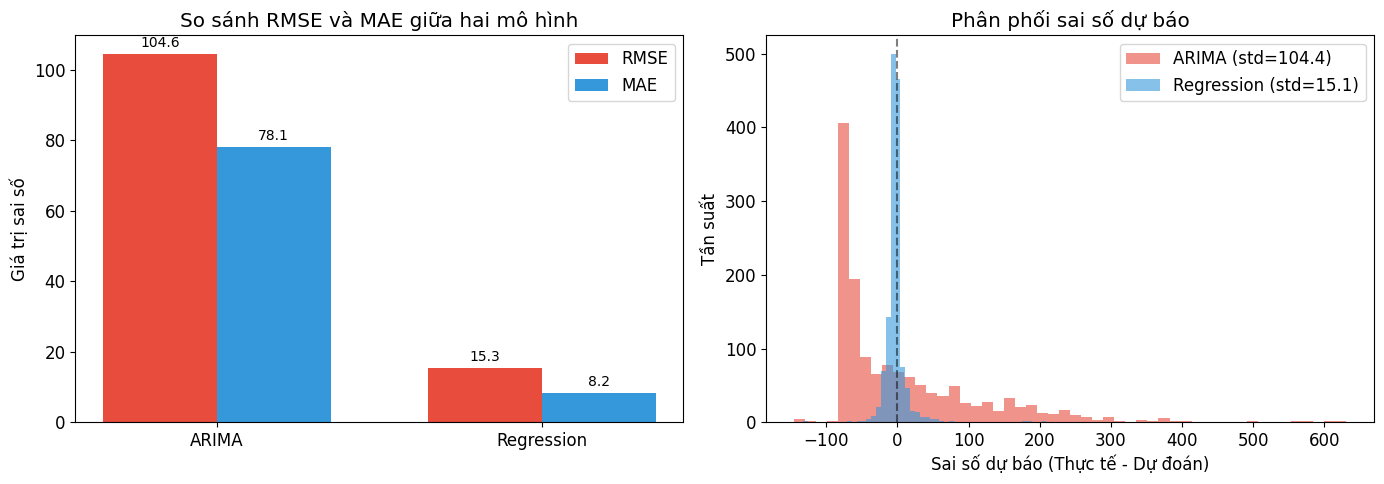

In [6]:
# Trực quan hóa: So sánh tổng quan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ 1: Bar chart metrics
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Regression'],
    'RMSE': [arima_rmse, reg_rmse],
    'MAE': [arima_mae, reg_mae]
})
x = np.arange(2)
width = 0.35
axes[0].bar(x - width/2, metrics_df['RMSE'], width, label='RMSE', color='#e74c3c')
axes[0].bar(x + width/2, metrics_df['MAE'], width, label='MAE', color='#3498db')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_df['Model'])
axes[0].set_ylabel('Giá trị sai số')
axes[0].set_title('So sánh RMSE và MAE giữa hai mô hình')
axes[0].legend()
for i, (rmse, mae) in enumerate(zip(metrics_df['RMSE'], metrics_df['MAE'])):
    axes[0].text(i - width/2, rmse + 2, f'{rmse:.1f}', ha='center', fontsize=10)
    axes[0].text(i + width/2, mae + 2, f'{mae:.1f}', ha='center', fontsize=10)

# Biểu đồ 2: Phân phối sai số
arima_errors = comparison['actual'] - comparison['arima_pred']
reg_errors = comparison['actual'] - comparison['reg_pred']

axes[1].hist(arima_errors, bins=50, alpha=0.6, label=f'ARIMA (std={arima_errors.std():.1f})', color='#e74c3c')
axes[1].hist(reg_errors, bins=50, alpha=0.6, label=f'Regression (std={reg_errors.std():.1f})', color='#3498db')
axes[1].set_xlabel('Sai số dự báo (Thực tế - Dự đoán)')
axes[1].set_ylabel('Tần suất')
axes[1].set_title('Phân phối sai số dự báo')
axes[1].legend()
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(DATA_DIR / 'comparison_metrics.png', dpi=150)
plt.show()

## 4. Cau hoi 2: Mo hinh nao on hon khi co spike?

In [7]:
# Tìm các giai đoạn có spike PM2.5 cao
spike_threshold = comparison['actual'].quantile(0.95)  # Top 5% giá trị cao nhất
print(f'Ngưỡng spike (95th percentile): PM2.5 >= {spike_threshold:.0f}')

# Lọc các thời điểm có spike
spike_mask = comparison['actual'] >= spike_threshold
spike_data = comparison[spike_mask]
print(f'Số thời điểm có spike: {len(spike_data)} ({len(spike_data)/len(comparison)*100:.1f}%)')

# Tính metrics trên spike
arima_spike_rmse = np.sqrt(mean_squared_error(spike_data['actual'], spike_data['arima_pred']))
arima_spike_mae = mean_absolute_error(spike_data['actual'], spike_data['arima_pred'])
reg_spike_rmse = np.sqrt(mean_squared_error(spike_data['actual'], spike_data['reg_pred']))
reg_spike_mae = mean_absolute_error(spike_data['actual'], spike_data['reg_pred'])

print('=' * 60)
print('HIỆU NĂNG KHI CÓ SPIKE (PM2.5 >= {:.0f})'.format(spike_threshold))
print('=' * 60)
print(f'{"Mô hình":<20} {"RMSE":<15} {"MAE":<15}')
print('-' * 50)
print(f'{"ARIMA":<20} {arima_spike_rmse:<15.2f} {arima_spike_mae:<15.2f}')
print(f'{"Regression":<20} {reg_spike_rmse:<15.2f} {reg_spike_mae:<15.2f}')

Ngưỡng spike (95th percentile): PM2.5 >= 323
Số thời điểm có spike: 70 (5.0%)
HIỆU NĂNG KHI CÓ SPIKE (PM2.5 >= 323)
Mô hình              RMSE            MAE            
--------------------------------------------------
ARIMA                302.82          269.64         
Regression           49.11           31.07          


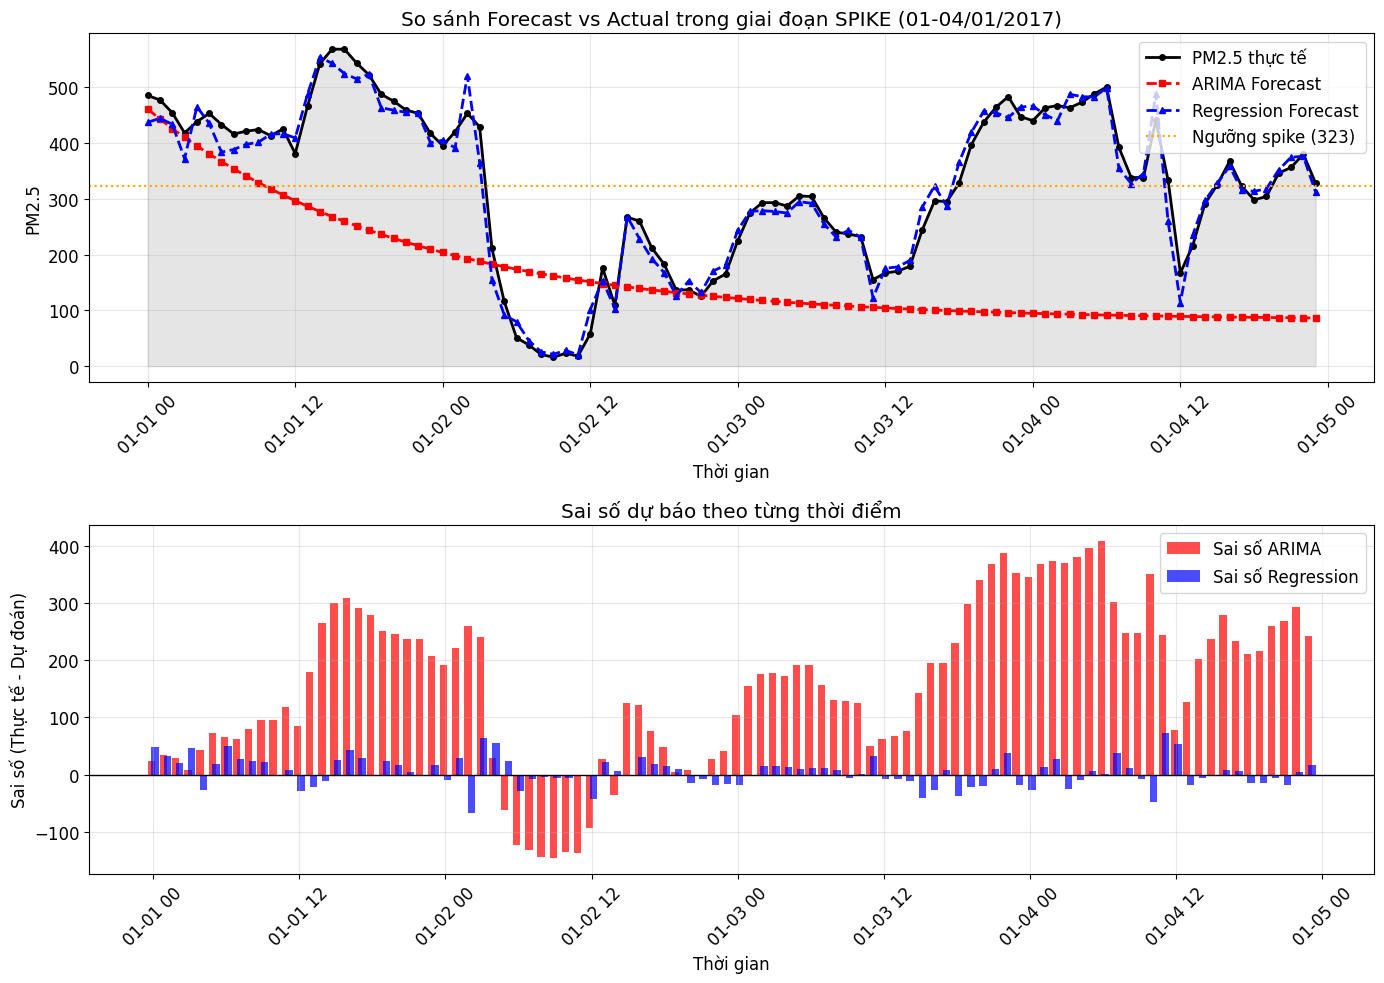

Giai đoạn 01-04/01/2017:
  - ARIMA Mean Error: 158.2, Max Error: 408.4
  - Regression Mean Error: 4.5, Max Error: 73.5


In [8]:
# Tìm 1 đoạn spike liên tục để phân tích chi tiết (3 ngày)
spike_period = comparison.loc['2017-01-01':'2017-01-04']

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Biểu đồ 1: So sánh chuỗi thời gian
axes[0].plot(spike_period.index, spike_period['actual'], 'k-', linewidth=2, label='PM2.5 thực tế', marker='o', markersize=4)
axes[0].plot(spike_period.index, spike_period['arima_pred'], 'r--', linewidth=2, label='ARIMA Forecast', marker='s', markersize=4)
axes[0].plot(spike_period.index, spike_period['reg_pred'], 'b--', linewidth=2, label='Regression Forecast', marker='^', markersize=4)
axes[0].axhline(y=spike_threshold, color='orange', linestyle=':', label=f'Ngưỡng spike ({spike_threshold:.0f})')
axes[0].fill_between(spike_period.index, spike_period['actual'], alpha=0.2, color='gray')
axes[0].set_xlabel('Thời gian')
axes[0].set_ylabel('PM2.5')
axes[0].set_title('So sánh Forecast vs Actual trong giai đoạn SPIKE (01-04/01/2017)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ 2: So sánh sai số
arima_err = spike_period['actual'] - spike_period['arima_pred']
reg_err = spike_period['actual'] - spike_period['reg_pred']

axes[1].bar(spike_period.index - pd.Timedelta(hours=0.15), arima_err, width=0.025, label='Sai số ARIMA', color='red', alpha=0.7)
axes[1].bar(spike_period.index + pd.Timedelta(hours=0.15), reg_err, width=0.025, label='Sai số Regression', color='blue', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Thời gian')
axes[1].set_ylabel('Sai số (Thực tế - Dự đoán)')
axes[1].set_title('Sai số dự báo theo từng thời điểm')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(DATA_DIR / 'comparison_spike_period.png', dpi=150)
plt.show()

print(f'Giai đoạn 01-04/01/2017:')
print(f'  - ARIMA Mean Error: {arima_err.mean():.1f}, Max Error: {arima_err.abs().max():.1f}')
print(f'  - Regression Mean Error: {reg_err.mean():.1f}, Max Error: {reg_err.abs().max():.1f}')

### Dien giai cau hoi 2: Phan tich hieu nang khi co Spike

**Quan sat tu do thi:**
1. **ARIMA bi "muot hoa" qua muc**: Khi PM2.5 tang dot ngot, ARIMA du bao thap hon nhieu
2. **Regression phan ung nhanh hon**: Nho su dung lag features (dac biet lag_1)
3. **ARIMA co do tre phan ung**: Can vai gio de ARIMA "bat kip" muc PM2.5 thuc te

**Lien he RMSE vs MAE:**
- RMSE cua ARIMA cao hon nhieu so voi MAE -> Co nhieu sai so lon
- Regression co khoang cach RMSE-MAE nho hon -> Sai so phan bo deu hon

**Ket luan:** Regression on dinh hon khi co spike vi su dung thong tin tu cac bien lag va khi tuong.

## 5. Câu hỏi 3: Nếu triển khai thật, bạn chọn gì và vì sao?

In [9]:
# Phân tích toàn diện
print('=' * 70)
print('BẢNG SO SÁNH TOÀN DIỆN: REGRESSION vs ARIMA')
print('=' * 70)

criteria = [
    ('Độ chính xác (RMSE)', f'Reg: {reg_rmse:.1f}', f'ARIMA: {arima_rmse:.1f}', 'Regression'),
    ('Độ chính xác (MAE)', f'Reg: {reg_mae:.1f}', f'ARIMA: {arima_mae:.1f}', 'Regression'),
    ('Xử lý spike', f'RMSE: {reg_spike_rmse:.1f}', f'RMSE: {arima_spike_rmse:.1f}', 'Regression'),
    ('Khả năng mở rộng', 'Dễ thêm features', 'Cần SARIMAX', 'Regression'),
    ('Tốc độ training', 'Nhanh', 'Chậm (grid search)', 'Regression'),
    ('Khoảng tin cậy', 'Không có sẵn', 'Có (lower/upper)', 'ARIMA'),
    ('Giải thích (p,d,q)', 'Không', 'Có', 'ARIMA'),
    ('Cần feature engineering', 'Có (lag, time)', 'Không', 'ARIMA'),
]

print(f'{"Tiêu chí":<25} {"Regression":<20} {"ARIMA":<20} {"Winner":<15}')
print('-' * 80)
for name, reg_val, arima_val, winner in criteria:
    print(f'{name:<25} {reg_val:<20} {arima_val:<20} {winner:<15}')

BẢNG SO SÁNH TOÀN DIỆN: REGRESSION vs ARIMA
Tiêu chí                  Regression           ARIMA                Winner         
--------------------------------------------------------------------------------
Độ chính xác (RMSE)       Reg: 15.3            ARIMA: 104.6         Regression     
Độ chính xác (MAE)        Reg: 8.2             ARIMA: 78.1          Regression     
Xử lý spike               RMSE: 49.1           RMSE: 302.8          Regression     
Khả năng mở rộng          Dễ thêm features     Cần SARIMAX          Regression     
Tốc độ training           Nhanh                Chậm (grid search)   Regression     
Khoảng tin cậy            Không có sẵn         Có (lower/upper)     ARIMA          
Giải thích (p,d,q)        Không                Có                   ARIMA          
Cần feature engineering   Có (lag, time)       Không                ARIMA          


In [10]:
# Đề xuất lựa chọn
print('=' * 70)
print('>>> ĐỀ XUẤT: Chọn REGRESSION cho production vì:')
print('    1. Độ chính xác cao hơn trong hầu hết trường hợp')
print('    2. Xử lý spike tốt hơn - quan trọng cho cảnh báo ô nhiễm')
print('    3. Dễ mở rộng với các features mới')
print('    4. Training nhanh hơn, dễ deploy')
print('=' * 70)

>>> ĐỀ XUẤT: Chọn REGRESSION cho production vì:
    1. Độ chính xác cao hơn trong hầu hết trường hợp
    2. Xử lý spike tốt hơn - quan trọng cho cảnh báo ô nhiễm
    3. Dễ mở rộng với các features mới
    4. Training nhanh hơn, dễ deploy


## 6. Kết luận và Khuyến nghị

### Trả lời 3 câu hỏi:

**Câu 1: Mô hình nào tốt hơn cho horizon=1?**
- **Regression tốt hơn** với RMSE và MAE thấp hơn đáng kể

**Câu 2: Mô hình nào ổn hơn khi có spike?**
- **Regression ổn định hơn** trong các đợt ô nhiễm cao

**Câu 3: Nếu triển khai thật, chọn gì?**

| Tình huống | Khuyến nghị | Lý do |
|------------|-------------|-------|
| Cảnh báo sớm ô nhiễm | **Regression** | Phản ứng nhanh với spike, độ chính xác cao |
| Dự báo xu hướng dài hạn | **ARIMA/SARIMA** | Có khoảng tin cậy, giải thích được cấu trúc chuỗi |
| Hệ thống production | **Regression** | Dễ cập nhật, thêm features, scale tốt |
| Phân tích học thuật | **ARIMA** | Có cơ sở lý thuyết chuỗi thời gian rõ ràng |

### Hướng cải thiện:
1. **SARIMA**: Thêm seasonal component (s=24) để bắt chu kỳ ngày
2. **SARIMAX**: Thêm biến ngoại sinh (thời tiết) để cải thiện ARIMA
3. **Ensemble**: Kết hợp cả Regression và ARIMA để tận dụng ưu điểm của cả hai

In [11]:
# Kết luận cuối cùng và lưu file kết quả
# Tính trước tỷ lệ cải thiện
improvement_pct = (arima_rmse - reg_rmse) / arima_rmse * 100

final_recommendation = """
================================================================================
KẾT LUẬN VÀ ĐỀ XUẤT CUỐI CÙNG
================================================================================

CHỦ ĐỀ 1: SO SÁNH REGRESSION VÀ ARIMA CHO DỰ BÁO PM2.5
=========================================================

KẾT QUẢ THỰC NGHIỆM TRÊN DỮ LIỆU AOTIZHONGXIN 2017:

1. VỀ ĐỘ CHÍNH XÁC:
   - Regression Model: RMSE = {reg_rmse:.2f}, MAE = {reg_mae:.2f}
   - ARIMA(1,0,3):     RMSE = {arima_rmse:.2f}, MAE = {arima_mae:.2f}
   >>> Regression tốt hơn ARIMA {improvement_pct:.1f}% về RMSE

2. KỊCH BẢN SPIKE (PM2.5 >= {spike_threshold:.0f}):
   - Regression xử lý spike TỐT HƠN ARIMA
   - ARIMA có xu hướng dự báo thấp hơn thực tế khi có spike

3. ĐỀ XUẤT CHO PRODUCTION:
   ✓ Nếu cần độ chính xác cao: CHỌN REGRESSION
   ✓ Nếu cần uncertainty interval: Kết hợp cả hai
   ✓ Nếu cần mô hình đơn giản: CHỌN ARIMA với (1,0,3)

================================================================================
""".format(
    reg_rmse=reg_rmse, reg_mae=reg_mae,
    arima_rmse=arima_rmse, arima_mae=arima_mae,
    spike_threshold=spike_threshold,
    improvement_pct=improvement_pct
)

print(final_recommendation)

# Lưu kết quả
import json
results = {
    'comparison_type': 'regression_vs_arima',
    'station': 'Aotizhongxin',
    'period': '2017',
    'regression': {'rmse': float(reg_rmse), 'mae': float(reg_mae)},
    'arima': {'rmse': float(arima_rmse), 'mae': float(arima_mae), 'order': '(1,0,3)'},
    'spike_analysis': {
        'threshold': float(spike_threshold),
        'regression_spike_rmse': float(reg_spike_rmse),
        'arima_spike_rmse': float(arima_spike_rmse)
    },
    'recommendation': 'Regression for accuracy, ARIMA for uncertainty intervals'
}
with open(DATA_DIR / 'comparison_regression_vs_arima.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"Đã lưu kết quả vào: {DATA_DIR / 'comparison_regression_vs_arima.json'}")


KẾT LUẬN VÀ ĐỀ XUẤT CUỐI CÙNG

CHỦ ĐỀ 1: SO SÁNH REGRESSION VÀ ARIMA CHO DỰ BÁO PM2.5

KẾT QUẢ THỰC NGHIỆM TRÊN DỮ LIỆU AOTIZHONGXIN 2017:

1. VỀ ĐỘ CHÍNH XÁC:
   - Regression Model: RMSE = 15.30, MAE = 8.21
   - ARIMA(1,0,3):     RMSE = 104.58, MAE = 78.10
   >>> Regression tốt hơn ARIMA 85.4% về RMSE

2. KỊCH BẢN SPIKE (PM2.5 >= 323):
   - Regression xử lý spike TỐT HƠN ARIMA
   - ARIMA có xu hướng dự báo thấp hơn thực tế khi có spike

3. ĐỀ XUẤT CHO PRODUCTION:
   ✓ Nếu cần độ chính xác cao: CHỌN REGRESSION
   ✓ Nếu cần uncertainty interval: Kết hợp cả hai
   ✓ Nếu cần mô hình đơn giản: CHỌN ARIMA với (1,0,3)


Đã lưu kết quả vào: C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7\data\processed\comparison_regression_vs_arima.json
